# Facial Emotion Recognition

**Facial emotion recognition** plays a crucial role in enhancing human-computer interaction, allowing machines to understand and respond to human emotions in a more natural and intuitive way. This technology has wide-ranging applications, from improving customer service through sentiment analysis, to supporting mental health professionals by providing additional insights into patients' emotional states. In educational settings, it can tailor learning experiences based on students' emotional responses, optimizing engagement and effectiveness. For individuals with autism or social communication challenges, facial emotion recognition software can offer valuable tools to recognize and interpret emotions in others, aiding in social integration and personal development.

## Import required libraries

In [3]:
import os
from glob import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix
from PIL import Image
import h5py

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from sklearn.metrics import classification_report

## Load Data

In [4]:
base = Path("/kaggle/input/facial-emotions/Images/Images")
train_df = pd.read_csv(base/ 'train.csv')
test_df = pd.read_csv(base/ 'test.csv')

In [5]:
train_df.head()

,Image,Emotion
0,Training_8254683.jpg,happy
1,Training_26161927.jpg,happy
2,Training_51519589.jpg,happy
3,Training_6599119.jpg,angry
4,Training_25525626.jpg,fear


In [6]:
test_df.head()

,Image,Emotion
0,PrivateTest_93913947.jpg,sad
1,PrivateTest_90978621.jpg,surprise
2,PublicTest_46362067.jpg,sad
3,PrivateTest_16765445.jpg,fear
4,PublicTest_48953105.jpg,disgust


## Data Preprocessing

In [7]:
train_df['Emotion'] = train_df['Emotion'].str.lower()

train_df['path'] = train_df['Image'].apply(lambda x: base / 'train' / f'{x}')
train_df['exists'] = train_df['path'].apply(lambda x: x.exists())

print(f"{train_df['exists'].sum()} images found of {train_df.shape[0]} total")

train_df['Emotion'] = train_df['Emotion'].astype('category')
train_df['emotion_numeric'] = train_df['Emotion'].cat.codes

train_df['emotion_categorical'] = train_df['emotion_numeric'].apply(lambda x: to_categorical(x, 1+train_df['emotion_numeric'].max()))

train_df.dropna(inplace = True)
train_df = train_df[train_df['exists']]

train_df.head()

28709 images found of 28709 total


,Image,Emotion,path,exists,emotion_numeric,emotion_categorical
0,Training_8254683.jpg,happy,/kaggle/input/facial-emotions/Images/Images/tr...,True,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,Training_26161927.jpg,happy,/kaggle/input/facial-emotions/Images/Images/tr...,True,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,Training_51519589.jpg,happy,/kaggle/input/facial-emotions/Images/Images/tr...,True,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,Training_6599119.jpg,angry,/kaggle/input/facial-emotions/Images/Images/tr...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,Training_25525626.jpg,fear,/kaggle/input/facial-emotions/Images/Images/tr...,True,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [8]:
test_df['Emotion'] = test_df['Emotion'].str.lower()

test_df['path'] = test_df['Image'].apply(lambda x: base / 'test' / f'{x}')
test_df['exists'] = test_df['path'].apply(lambda x: x.exists())

print(f"{test_df['exists'].sum()} images found of {test_df.shape[0]} total")

test_df['Emotion'] = test_df['Emotion'].astype('category')
test_df['emotion_numeric'] = test_df['Emotion'].cat.codes

test_df['emotion_categorical'] = test_df['emotion_numeric'].apply(lambda x: to_categorical(x, 1+test_df['emotion_numeric'].max()))

test_df.dropna(inplace = True)
test_df = test_df[test_df['exists']]

test_df.head()

7178 images found of 7178 total


,Image,Emotion,path,exists,emotion_numeric,emotion_categorical
0,PrivateTest_93913947.jpg,sad,/kaggle/input/facial-emotions/Images/Images/te...,True,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1,PrivateTest_90978621.jpg,surprise,/kaggle/input/facial-emotions/Images/Images/te...,True,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,PublicTest_46362067.jpg,sad,/kaggle/input/facial-emotions/Images/Images/te...,True,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,PrivateTest_16765445.jpg,fear,/kaggle/input/facial-emotions/Images/Images/te...,True,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,PublicTest_48953105.jpg,disgust,/kaggle/input/facial-emotions/Images/Images/te...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [9]:
unique_emotions = list(train_df['Emotion'].unique())
unique_emotions

['happy', 'angry', 'fear', 'neutral', 'surprise', 'sad', 'disgust']

## Examine and balance the distribution of emotions

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


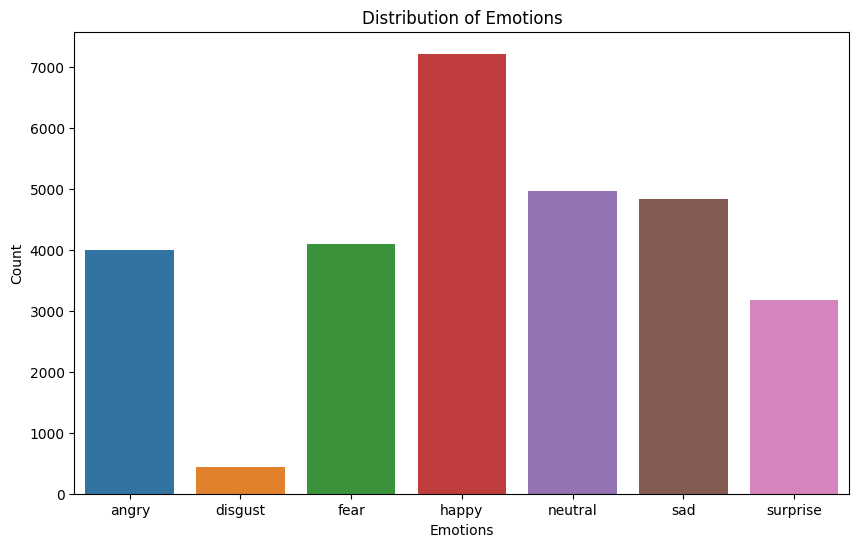

In [10]:
# Distribution of Emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=train_df)
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [11]:
def balance_data(df, class_size):
    balanced_df = df.groupby(['Emotion']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', balanced_df.shape[0], 'Old Size:', df.shape[0])
    return balanced_df

/tmp/ipykernel_30/2651391301.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_df = df.groupby(['Emotion']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
/tmp/ipykernel_30/2651391301.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(['Emotion']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)


New Data Size: 50505 Old Size: 28709


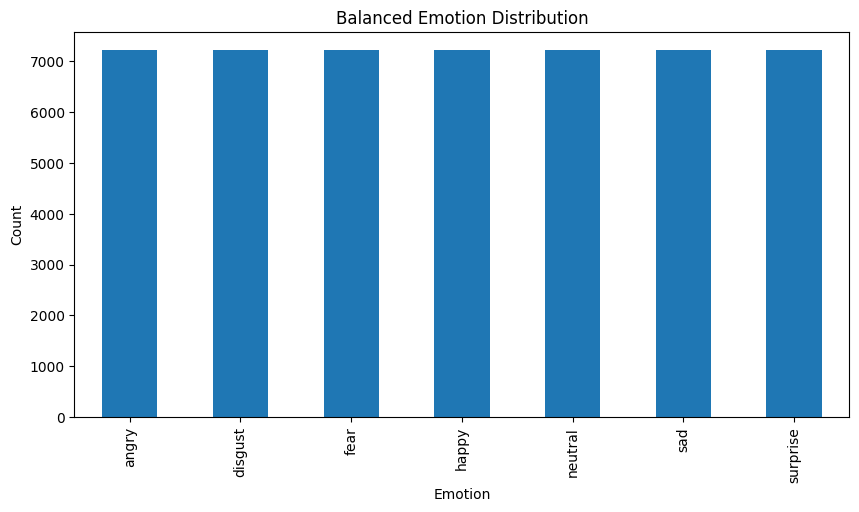

In [12]:
class_size = train_df['Emotion'].value_counts().max()
train_df_balanced = balance_data(train_df, class_size)
train_df_balanced['Emotion'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Balanced Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [13]:
df = pd.concat([train_df_balanced,test_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

57683

In [14]:
im = Image.open(train_df_balanced['path'][1])
width, height = im.size
print(width,height)

48 48


## Data augmentation

In [15]:
def create_data_generators(train_df, test_df, x_col, y_col, target_size, batch_size):

    train_df[x_col] = train_df[x_col].astype(str)
    test_df[x_col] = test_df[x_col].astype(str)

    # data augmentation parameters for the training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # data generator for the training set
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True
    )

    # data generator for the test set
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )

    return train_generator, test_generator

In [16]:
batch_size = 128
target_size = (48, 48)
x_col = 'path'  
y_col = 'Emotion'
train_generator, test_generator = create_data_generators(train_df_balanced, test_df, x_col, y_col, target_size, batch_size)

Found 50505 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


## Test Data

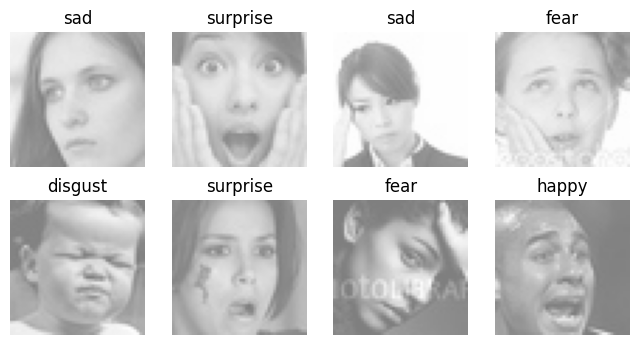

In [17]:
t_x, t_y = next(test_generator)
emotion_mapping = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
fig, m_axs = plt.subplots(2, 4, figsize = (8, 4))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    emotion_index = np.argmax(c_y, -1)
    emotion_name = emotion_mapping.get(emotion_index, 'Unknown')
    c_ax.set_title(f'{emotion_name}')
    c_ax.axis('off')

## Train Data

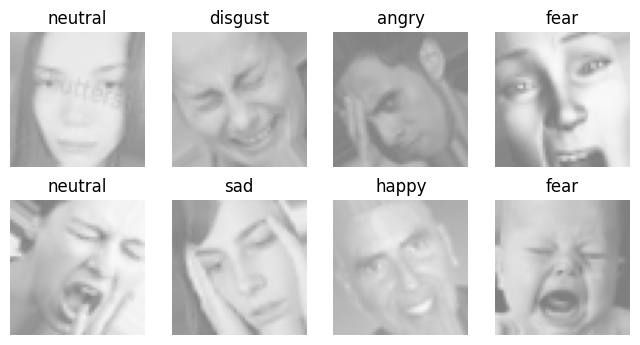

In [18]:
t_x, t_y = next(train_generator)
emotion_mapping = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
fig, m_axs = plt.subplots(2, 4, figsize = (8, 4))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    emotion_index = np.argmax(c_y, -1)
    emotion_name = emotion_mapping.get(emotion_index, 'Unknown')
    c_ax.set_title(f'{emotion_name}')
    c_ax.axis('off')

## Model

In [19]:
model = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 3)),
    
    # 1st block
    layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # 2nd block
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # 3rd block
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=2),
    
    # 4th block
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # 5th block
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    
    # Output layer
    layers.Dense(len(unique_emotions), activation='softmax'),
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,794,247 (18.29 MB)

 Trainable params: 4,793,959 (18.29 MB)

 Non-trainable params: 288 (1.12 KB)

In [20]:
es = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.01)

In [21]:
model_history = model.fit(train_generator, epochs = 10, verbose = 1, 
                           validation_data = test_generator, callbacks = [es])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727717865.988863     106 service.cc:145] XLA service 0x7e7e5c0189d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727717865.988925     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/395 ━━━━━━━━━━━━━━━━━━━━ 2:06:53 19s/step - accuracy: 0.1484 - loss: 3.0139

I0000 00:00:1727717877.738882     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/395 ━━━━━━━━━━━━━━━━━━━━ 164s 366ms/step - accuracy: 0.2202 - loss: 1.9788 - val_accuracy: 0.2442 - val_loss: 2.2740
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 228ms/step - accuracy: 0.4030 - loss: 1.5504 - val_accuracy: 0.4244 - val_loss: 1.4994
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 92s 230ms/step - accuracy: 0.4917 - loss: 1.3242 - val_accuracy: 0.4567 - val_loss: 1.4106
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 93s 232ms/step - accuracy: 0.5457 - loss: 1.1917 - val_accuracy: 0.4940 - val_loss: 1.3284
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 93s 231ms/step - accuracy: 0.5822 - loss: 1.0912 - val_accuracy: 0.4741 - val_loss: 1.4451
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 93s 231ms/step - accuracy: 0.6146 - loss: 1.0210 - val_accuracy: 0.5235 - val_loss: 1.3142
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 92s 228ms/step - accuracy: 0.6337 - loss: 0.9696 - val_accuracy: 0.5355 - val_loss: 1.2921
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 92s 229ms/step - accuracy: 0.6559 - loss: 0.9165 - va

## Analyse Convergence

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

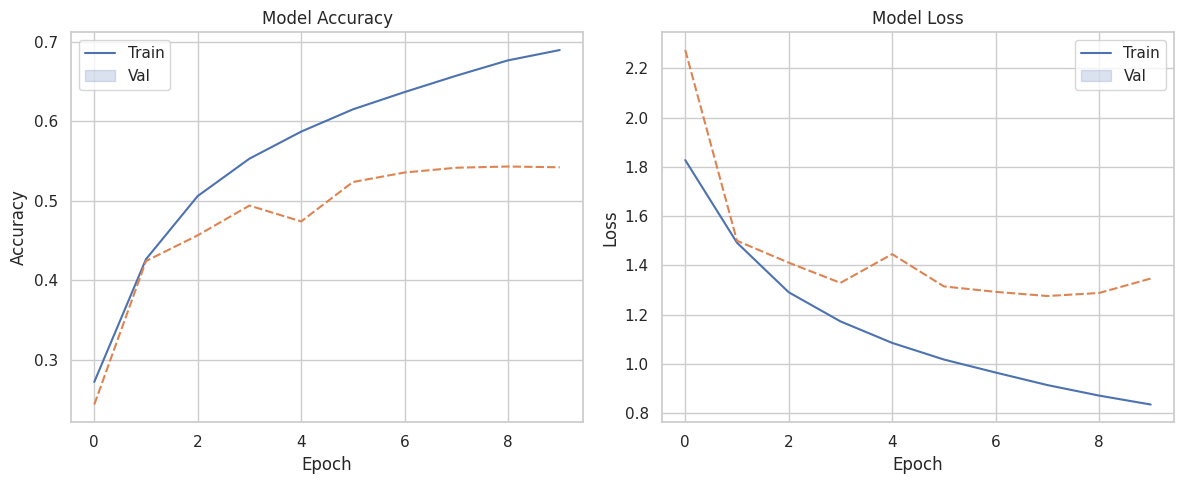

In [22]:
hist_df = pd.DataFrame(model_history.history)

sns.set(style='whitegrid')

# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) 
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.tight_layout() 
plt.show()

## Evaluate the result

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step


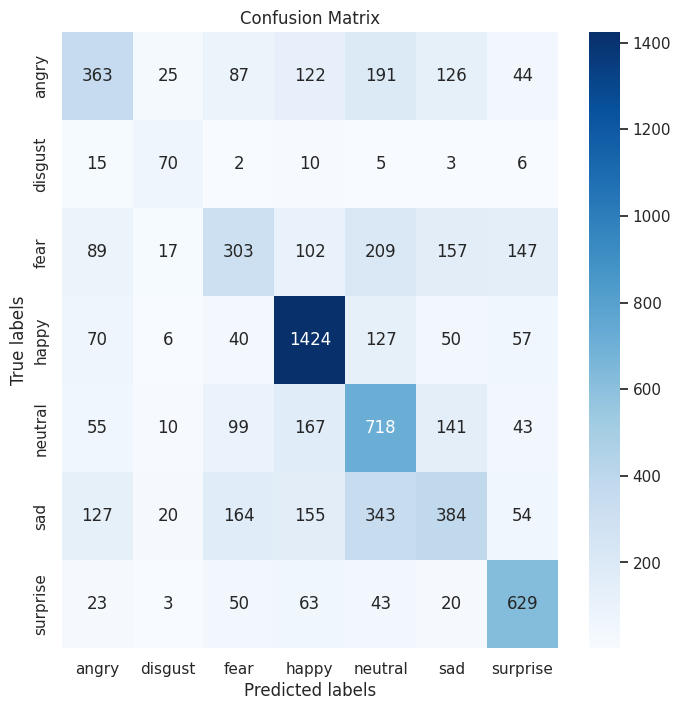

In [23]:
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys()) 

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
predictions_labels = np.argmax(predictions, axis=1)

In [25]:
print(classification_report(test_df["emotion_numeric"], predictions_labels))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       958
           1       0.46      0.63      0.53       111
           2       0.41      0.30      0.34      1024
           3       0.70      0.80      0.75      1774
           4       0.44      0.58      0.50      1233
           5       0.44      0.31      0.36      1247
           6       0.64      0.76      0.69       831

    accuracy                           0.54      7178
   macro avg       0.51      0.54      0.52      7178
weighted avg       0.53      0.54      0.53      7178



In [26]:
import keras
# Saving the model
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)
keras.saving.save_model(model, 'emotiondetector.keras')